git hub https://github.com/LeonelAvVi/InteligenciaII.git

carpeta de Dataset: https://drive.google.com/drive/folders/14MZNuZg5xmbKtR3L9Wq_Tdwu9eyNliL6?usp=sharing


In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image 

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cp -av /content/drive/MyDrive/universidad/inteligencia2/lab3/dataset_flores /content/dataImg


'/content/drive/MyDrive/universidad/inteligencia2/lab3/dataset_flores' -> '/content/dataImg/dataset_flores'


In [9]:
import os
path ='/content/dataImg/'
directorio = os.listdir(path)
directorio

['tagetes', 'Hibisco', 'FlorRita', 'claveles', 'lirio', 'Girasoles', 'rosas']

In [10]:
labels_def = {'tagetes':0, 'Hibisco':1, 'Girasoles':2,'FlorRita':3,'claveles':4, 'lirio':5 ,'rosas':6}
labels_def

{'FlorRita': 3,
 'Girasoles': 2,
 'Hibisco': 1,
 'claveles': 4,
 'lirio': 5,
 'rosas': 6,
 'tagetes': 0}

In [11]:
import numpy as np
images =[]
labels = []
for d in directorio:
   imagenes = os.listdir(path + d)
   for i in imagenes:
       imgPath2 = path + d + '/' + i
       images.append(imgPath2)
       labels.append(labels_def[d])

In [12]:
X_train = images
labels_train = labels

In [13]:
def getName(label):
  for key in labels_def:
      if labels_def[key] == label:
        return(key)

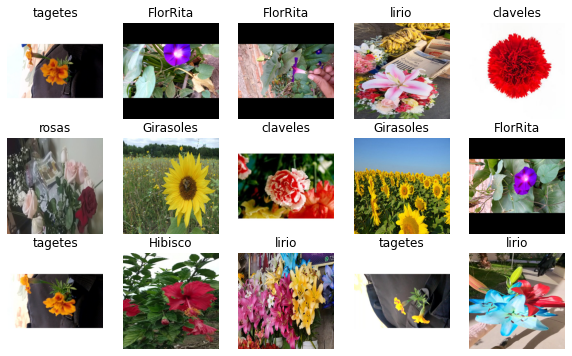

In [14]:
import random 
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(X_train)-1)
    img = io.imread(X_train[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(getName(labels_train[ix]))
plt.show()

In [15]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(X_train, labels_train, test_size=0.07, stratify=labels_train)

len(train_imgs), len(test_imgs)

(7227, 544)

In [16]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y
    # self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img1 = Image.open(self.X[ix])
    new_img = img1.resize((32,32))
    #images.append(np.array(new_img)/255)
    return torch.from_numpy((np.array(new_img))/255.).float().permute(2,0,1), torch.tensor(self.y[ix])

In [17]:
dataset = {
    'train': Dataset(train_imgs, train_labels), 
    'test': Dataset(test_imgs, test_labels)
}
Xtrain = dataset['train']
XText = dataset['test']

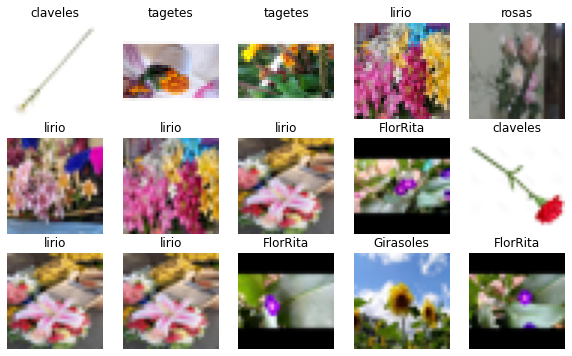

In [18]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(getName(lab))
plt.show()

In [19]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 32, 32])

In [20]:
from torchvision.ops.misc import ConvNormActivation

In [53]:
from torch.nn.modules.activation import ReLU6
def block(k=3, p=1, s=2, pk=2, ps=2):
    return ConvNormActivation(
          torch.nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
          torch.nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU()
        )

In [54]:
def InvertedResidual_1(k=3, p=1, s=2, pk=2, ps=2):
    return torch.nn.Sequential(
        ConvNormActivation(
          torch.nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
          torch.nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU()
        ),
        torch.nn.Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False),
        torch.nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    )

In [55]:
def InvertedResidual_2(k=3, p=1, s=2, pk=2, ps=2):
    return torch.nn.Sequential(
        ConvNormActivation(
          torch.nn.Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False),
          torch.nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU()
        ),
        ConvNormActivation(
          torch.nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=96, bias=False),
          torch.nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU()
        ),
        torch.nn.Conv2d(96, 24, kernel_size=(1, 1), stride=(1, 1), bias=False),
        torch.nn.BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    )

In [56]:
def InvertedResidual_3(k=3, p=1, s=2, pk=2, ps=2):
    return torch.nn.Sequential(
        ConvNormActivation(
          torch.nn.Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False),
          torch.nn.BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU()
        ),
        ConvNormActivation(
          torch.nn.Conv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=144, bias=False),
          torch.nn.BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU()
        ),
        torch.nn.Conv2d(144, 24, kernel_size=(1, 1), stride=(1, 1), bias=False),
        torch.nn.BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    )

In [57]:
def InvertedResidual_4(k=3, p=1, s=2, pk=2, ps=2):
    return torch.nn.Sequential(
        ConvNormActivation(
          torch.nn.Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False),
          torch.nn.BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU()
        ),
        ConvNormActivation(
          torch.nn.Conv2d(144, 144, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=144, bias=False),
          torch.nn.BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU()
        ),
        torch.nn.Conv2d(144, 32, kernel_size=(1, 1), stride=(1, 1), bias=False),
        torch.nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    )

In [58]:
def InvertedResidual_5( k=3, p=1, s=2, pk=2, ps=2):
    return torch.nn.Sequential(
        ConvNormActivation(
          torch.nn.Conv2d(32, 192, kernel_size=(1, 1), stride=(1, 1), bias=False),
          torch.nn.BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU()
        ),
        ConvNormActivation(
          torch.nn.Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=192, bias=False),
          torch.nn.BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU()
        ),
        torch.nn.Conv2d(192, 32, kernel_size=(1, 1), stride=(1, 1), bias=False),
        torch.nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    )

In [59]:
def InvertedResidual_7( k=3, p=1, s=2, pk=2, ps=2):
    return torch.nn.Sequential(
        ConvNormActivation(
          torch.nn.Conv2d(32, 192, kernel_size=(1, 1), stride=(1, 1), bias=False),
          torch.nn.BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU()
        ),
        ConvNormActivation(
          torch.nn.Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=192, bias=False),
          torch.nn.BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU()
        ),
        torch.nn.Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False),
        torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    )

In [60]:
def InvertedResidual_8(k=3, p=1, s=2, pk=2, ps=2):
    return torch.nn.Sequential(
        ConvNormActivation(
          torch.nn.Conv2d(64, 384, kernel_size=(1, 1), stride=(1, 1), bias=False),
          torch.nn.BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU()
        ),
        ConvNormActivation(
          torch.nn.Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=384, bias=False),
          torch.nn.BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU()
        ),
        torch.nn.Conv2d(384, 64, kernel_size=(1, 1), stride=(1, 1), bias=False),
        torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    )

In [61]:
def InvertedResidual_11(k=3, p=1, s=2, pk=2, ps=2):
    return torch.nn.Sequential(
        ConvNormActivation(
          torch.nn.Conv2d(64, 384, kernel_size=(1, 1), stride=(1, 1), bias=False),
          torch.nn.BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU()
        ),
        ConvNormActivation(
          torch.nn.Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=384, bias=False),
          torch.nn.BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU()
        ),
        torch.nn.Conv2d(384, 96, kernel_size=(1, 1), stride=(1, 1), bias=False),
        torch.nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    )

In [62]:
def InvertedResidual_12(k=3, p=1, s=2, pk=2, ps=2):
    return torch.nn.Sequential(
        ConvNormActivation(
          torch.nn.Conv2d(96, 576, kernel_size=(1, 1), stride=(1, 1), bias=False),
          torch.nn.BatchNorm2d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU()
        ),
        ConvNormActivation(
          torch.nn.Conv2d(576, 576, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=576, bias=False),
          torch.nn.BatchNorm2d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU()
        ),
        torch.nn.Conv2d(576, 96, kernel_size=(1, 1), stride=(1, 1), bias=False),
        torch.nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    )

In [63]:
def InvertedResidual_14(k=3, p=1, s=2, pk=2, ps=2):
    return torch.nn.Sequential(
        ConvNormActivation(
          torch.nn.Conv2d(96, 576, kernel_size=(1, 1), stride=(1, 1), bias=False),
          torch.nn.BatchNorm2d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU()
        ),
        ConvNormActivation(
          torch.nn.Conv2d(576, 576, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=576, bias=False),
          torch.nn.BatchNorm2d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU6()
        ),
        torch.nn.Conv2d(576, 160, kernel_size=(1, 1), stride=(1, 1), bias=False),
        torch.nn.BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    )

In [64]:
def InvertedResidual_15( k=3, p=1, s=2, pk=2, ps=2):
    return torch.nn.Sequential(
        ConvNormActivation(
          torch.nn.Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False),
          torch.nn.BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU()
        ),
        ConvNormActivation(
          torch.nn.Conv2d(960, 960, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=960, bias=False),
          torch.nn.BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU()
        ),
        torch.nn.Conv2d(960, 160, kernel_size=(1, 1), stride=(1, 1), bias=False),
        torch.nn.BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    )

In [65]:
def InvertedResidual_17(k=3, p=1, s=2, pk=2, ps=2):
    return torch.nn.Sequential(
        ConvNormActivation(
          torch.nn.Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False),
          torch.nn.BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU()
        ),
        ConvNormActivation(
          torch.nn.Conv2d(960, 960, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=960, bias=False),
          torch.nn.BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU()
        ),
        torch.nn.Conv2d(960, 320, kernel_size=(1, 1), stride=(1, 1), bias=False),
        torch.nn.BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    )

In [66]:
def InvertedResidual_18(k=3, p=1, s=2, pk=2, ps=2):
    return ConvNormActivation(
          torch.nn.Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False),
          torch.nn.BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          torch.nn.ReLU()
        )

In [67]:
# from torch.nn.modules.activation import ReLU6
# def block(c_in, c_out, k=3, p=1, s=2, pk=2, ps=2):
#     return torch.nn.Sequential(
#         ConvNormActivation(
#           torch.nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
#           torch.nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#           torch.nn.ReLU6(inplace=True)
#         )
#     )
class CNN(torch.nn.Module):
  def __init__(self, n_channels=3, n_outputs=6):
    super().__init__()
    self.conv1 = block()
    self.conv2 = InvertedResidual_1()
    self.conv3 = InvertedResidual_2()
    self.conv4 = InvertedResidual_3()
    self.conv5 = InvertedResidual_4()
    self.conv6 = InvertedResidual_5()
    self.conv7 = InvertedResidual_5()
    self.conv8 = InvertedResidual_7()
    self.conv9 = InvertedResidual_8()
    self.conv10 = InvertedResidual_8()
    self.conv11 = InvertedResidual_8()
    self.conv12 = InvertedResidual_12()
    self.conv13 = InvertedResidual_12()
    self.conv14 = InvertedResidual_14()
    self.conv15 = InvertedResidual_15()
    self.conv16 = InvertedResidual_15()
    self.conv17 = InvertedResidual_17()
    self.conv18 = InvertedResidual_18()

  def forward(self, x):
    x=self.conv1(x)
    x=self.conv2(x)
    x=self.conv3(x)
    x=self.conv4(x)
    x=self.conv5(x)
    x=self.conv6(x)
    x=self.conv7(x)
    x=self.conv8(x)
    x=self.conv9(x)
    x=self.conv10(x)
    x=self.conv11(x)
    x=self.conv12(x)
    x=self.conv13(x)
    x=self.conv14(x)
    x=self.conv15(x)
    x=self.conv16(x)
    x=self.conv17(x)
    x=self.conv18(x)
    x = torch.nn.Sequential(x)
    x = self.fc(x)
    print("Salida: ", x.shape)
    return x

In [68]:
model = CNN()

output = model(torch.randn(64, 3, 92, 92))

TypeError: ignored